# Pythonではじめる機械学習

## はじめての（簡単な）機械学習アプリケーション

増加するwebリクエストに対応したいと考えている。余分なサーバ費用をできるだけ発生させずに、サーバを増築しなければならない時期を事前に予測したい。

### データを読み込む

**ch01/data/web_traffic.tsv**というファイルでwebリクエストに関するデータが保存されている。

In [16]:
import scipy as sp
data = sp.genfromtxt("web_traffic.tsv", delimiter="\t")

読み込んだファイルを出力してみると、行ごとに時間の**インデックス**とその時間における**アクセス数**が入力されている。

In [17]:
print(data[:10])

[[  1.00000000e+00   2.27200000e+03]
 [  2.00000000e+00              nan]
 [  3.00000000e+00   1.38600000e+03]
 [  4.00000000e+00   1.36500000e+03]
 [  5.00000000e+00   1.48800000e+03]
 [  6.00000000e+00   1.33700000e+03]
 [  7.00000000e+00   1.88300000e+03]
 [  8.00000000e+00   2.28300000e+03]
 [  9.00000000e+00   1.33500000e+03]
 [  1.00000000e+01   1.02500000e+03]]


In [18]:
print(data.shape)

(743, 2)


ここでは、2次元のデータポイントが743個あることが分かる。

### 前処理とデータ整形

In [19]:
x = data[:,0]
y = data[:,1]

In [20]:
print(sp.sum(sp.isnan(y)))

8


In [21]:
x = x[~sp.isnan(y)]
y = y[~sp.isnan(y)]

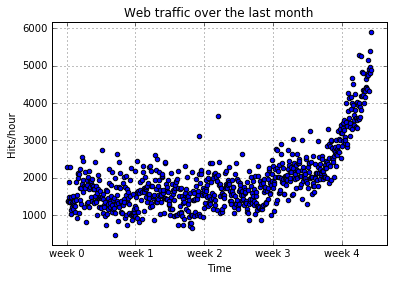

In [22]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.scatter(x,y)

plt.title("Web traffic over the last month")
plt.xlabel("Time")
plt.ylabel("Hits/hour")
plt.xticks([w*7*24 for w in range(10)], ['week %i'%w for w in range(10)])
plt.autoscale(tight=True)
plt.grid()
plt.show()